**Handling Series**

No módulo anterior, mostramos como carregar um único arquivo dicom e como pré-processar a imagem dicom. Nosso próximo passo será entender como arquivos dicom únicos se unem para construir uma série dicom, ou um estudo dicom. Neste projeto, vamos nos concentrar em entender como lidar com séries dicom e a hierarquia de certas tags dicom.

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()
!conda install -c conda-forge gdcm
!pip install pydicom==2.0.0

from google.colab import drive
drive.mount('/content/drive')

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.

In [1]:
!find "drive/MyDrive/Curso IA para Medicina - Cientista de Dados/1. Introdução Imagens Médicas/Dicom Hands-On/modules/" -name "*.py" -exec cp {} ./ \;

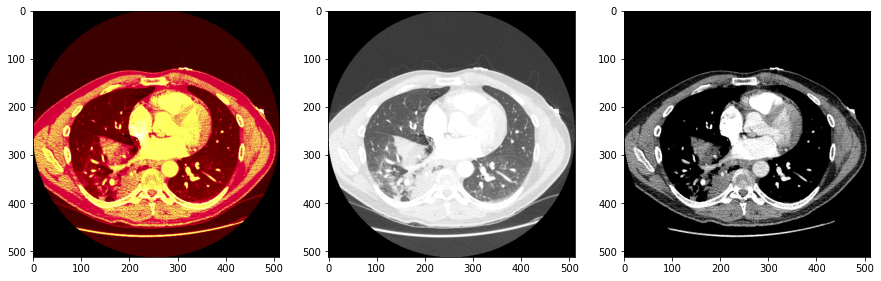

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils_pt1 as utils

DATASET_FOLDER = 'drive/MyDrive/Curso IA para Medicina - Cientista de Dados/1. Introdução Imagens Médicas/Dicom Hands-On/sample_train/'
dcm_file = DATASET_FOLDER + '1ac673a65484/43e3fab0e6a7/5fe509226d61.dcm'

window_center_list = [-600, 30, 400]
window_width_list = [1500, 150, 1800]
img_multi = utils.get_dicom_img(dcm_file, window_center_list, window_width_list)
img_lung = utils.get_dicom_img(dcm_file, -600, 1500)
img_original = utils.get_dicom_img(dcm_file)

f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(img_multi)
axarr[1].imshow(img_lung, cmap='gray')
axarr[2].imshow(img_original, cmap='gray')


**Building a Pandas Dataframe for Dicom files in a folder**

Imagine que temos uma pasta com vários arquivos dicom de diferentes exames que queremos processar (passá-los por um modelo de aprendizado de máquina ou simplesmente coletar dados). Neste caso, tudo o que temos é uma série de arquivos dicom. Mas sabemos que alguns desses arquivos dicom fazem parte de uma mesma série e, quando reunidos, formam uma imagem tridimensional de um paciente. Eles são chamados de Séries Dicom, e a série à qual um arquivo dicom específico pertence pode ser encontrada na tag dicom SeriesInstanceUID. Na verdade, existe uma hierarquia de fatias, séries e estudos, mas veremos isso em outro módulo. Por enquanto, tudo o que precisamos saber é que um arquivo dicom pode fazer parte de uma série dicom.

A primeira coisa que precisamos fazer é identificar quais arquivos dicom formam uma série e como ordená-los. Vamos agora construir uma função que verifica todos os arquivos dicom dentro de uma pasta e coleta várias tags dicom de cada arquivo. No final, construímos um dataframe de pandas que contém todas essas informações. Isso nos permitirá construir a imagem 3D de cada série.

A seguinte função recebe 2 parâmetros: uma pasta que deve ser escaneada e um dicionário chamado 'dicom_fileds', onde cada chave representa uma tag dicom que queremos recuperar e inserir no dataframe e cada chave possui outro dicionário associado ao seu valor que indica se essa chave é obrigatória ou não. Se uma chave for obrigatória e estiver faltando em um arquivo dicom, esse arquivo será simplesmente ignorado. Isso é útil quando queremos processar apenas arquivos dicom com determinadas tags.

In [3]:
def get_valid_files_in_folder(folder, dicom_fields):
    path_list = []
    field_lists = {field:[] for field in dicom_fields.keys()}
    for root, directories, files in os.walk(folder):
        for item in files:
            path = os.path.join(root, item)
            try:
                ds = utils.read_dicom(path)
                value_dict = {}
                for field in dicom_fields.keys():
                    if dicom_fields[field]['mandatory']:
                        value_dict[field] = getattr(ds, field)
                    else:
                        value_dict[field] = getattr(ds, field, 'Null')
            except Exception as e:
                print(e)
                continue
            path_list.append(path)
            for field in dicom_fields.keys():
                field_lists[field].append(value_dict[field])

    field_lists['path'] = path_list

    df = pd.DataFrame()
    for field in field_lists.keys():
        df[field] = field_lists[field]
        
    id_list = df['SeriesInstanceUID'].unique()

    return df

**Recuperando informações de arquivos Dicom**

Na célula a seguir, simplesmente chamamos essa função passando para ela a pasta que contém os arquivos dicom e o dicionário dicom_fields.

Vamos primeiro entender os campos que estamos solicitando:

- **SOPInstanceUID:** Um identificador único associado a cada arquivo dicom (slice);
- **SeriesInstanceUID:** Um identificador exclusivo associado a cada série dicom. Várias fatias dicom podem ser associadas ao mesmo SeriesInstanceUID (somente se a série tiver várias fatias). Em alguns casos (raios-x, por exemplo), cada série possui um único corte;
- **SeriesDescription:**  A descrição do que uma determinada série representa;
- **StudyInstanceUID:** Um identificador exclusivo associado a cada estudo. Um estudo representa uma coleção de séries obtidas durante uma sessão de exame. Essa hierarquia é apresentada na figura abaixo, onde podemos ver que cada estudo pode ter uma ou mais séries, e cada paciente pode ter um ou mais estudos;
- **InstanceNumber:** Um número de identificação que indica uma fatia na série. Este atributo indica uma ordem das fatias, e veremos um pouco mais disso nas células a seguir;
- **AccessionNumber:** Semelhante ao id do estudo: representa um identificador exclusivo do estudo;
- **PatientID:**  identificador único associado a cada paciente;
- **ImagePositionPatient:** Uma tupla de 3 que indica a posição do canto superior esquerdo no espaço tridimensional. A 3-tupla representa as posições nos eixos X, Y e Z.

![photo](https://drive.google.com/uc?id=1XdsOXHU9awP1V5282Xj-BTeWPHxL7kk2)


In [4]:
dicom_fields = {   'SOPInstanceUID':{'mandatory':True},
                    'SeriesInstanceUID':{'mandatory':True},
                    'SeriesDescription':{'mandatory':False},
                    'StudyInstanceUID':{'mandatory':True},
                    'InstanceNumber':{'mandatory':True},
                    'AccessionNumber':{'mandatory':False},
                    'PatientID':{'mandatory':False},
                    'ImagePositionPatient':{'mandatory':False}
                }

df = get_valid_files_in_folder(DATASET_FOLDER, dicom_fields)
df

,SOPInstanceUID,SeriesInstanceUID,SeriesDescription,StudyInstanceUID,InstanceNumber,AccessionNumber,PatientID,ImagePositionPatient,path
0,0ccdc5c6d74f,15421737f6d6,Null,1f169031216e,144,Null,Null,"[-160.900, -154.100, -159.250]",drive/MyDrive/Curso IA para Medicina - Cientis...
1,05cb11f3fb4a,15421737f6d6,Null,1f169031216e,176,Null,Null,"[-160.900, -154.100, -199.250]",drive/MyDrive/Curso IA para Medicina - Cientis...
2,0fe7a40d58b0,15421737f6d6,Null,1f169031216e,69,Null,Null,"[-160.900, -154.100, -65.500]",drive/MyDrive/Curso IA para Medicina - Cientis...
3,0082f269b16c,15421737f6d6,Null,1f169031216e,33,Null,Null,"[-160.900, -154.100, -20.500]",drive/MyDrive/Curso IA para Medicina - Cientis...
4,0a11025cf554,15421737f6d6,Null,1f169031216e,194,Null,Null,"[-160.900, -154.100, -221.750]",drive/MyDrive/Curso IA para Medicina - Cientis...
...,...,...,...,...,...,...,...,...,...
723,35d76b0e75be,43e3fab0e6a7,Null,1ac673a65484,162,Null,Null,"[-175.400, -192.500, -202.750]",drive/MyDrive/Curso IA para Medicina - Cientis...
724,f2c4a237bbf5,43e3fab0e6a7,Null,1ac673a65484,82,Null,Null,"[-175.400, -192.500, -102.750]",drive/MyDrive/Curso IA para Medicina - Cientis...
725,389e6e04dbad,43e3fab0e6a7,Null,1ac673a65484,94,Null,Null,"[-175.400, -192.500, -117.750]",drive/MyDrive/Curso IA para Medicina - Cientis...
726,3794a8887bdb,43e3fab0e6a7,Null,1ac673a65484,160,Null,Null,"[-175.400, -192.500, -200.250]",drive/MyDrive/Curso IA para Medicina - Cientis...


Agora temos um dataframe com vários dados de cada arquivo dicom. Agora podemos verificar quantas séries diferentes temos em nossa pasta e quantas fatias cada série possui:

In [5]:
print(f'Unique SeriesInstanceUID = {df.SeriesInstanceUID.unique()}')
for series in df.SeriesInstanceUID.unique():
  df_ser = df[df['SeriesInstanceUID'] == series]
  print(f'SeriesInstanceUID = {series}: {df_ser.shape[0]} slices')

Unique SeriesInstanceUID = ['15421737f6d6' '4ebaa4fa0361' '43e3fab0e6a7']
SeriesInstanceUID = 15421737f6d6: 257 slices
SeriesInstanceUID = 4ebaa4fa0361: 225 slices
SeriesInstanceUID = 43e3fab0e6a7: 246 slices


**Ordering the Slices of a Dicom Series**

Para converter uma lista de arquivos dicom da mesma série em uma imagem 3D, primeiro precisamos ordenar todas as fatias dentro da mesma série de acordo com o número da instância. Na célula a seguir, faremos isso apenas para uma série:

In [6]:
series = '15421737f6d6'
df_ser = df[df['SeriesInstanceUID'] == series]
df_ser = df_ser.sort_values(by=['InstanceNumber'])
df_ser.reset_index(drop=True, inplace=True)
df_ser

,SOPInstanceUID,SeriesInstanceUID,SeriesDescription,StudyInstanceUID,InstanceNumber,AccessionNumber,PatientID,ImagePositionPatient,path
0,ec135e5f4f92,15421737f6d6,Null,1f169031216e,1,Null,Null,"[-160.900, -154.100, 19.500]",drive/MyDrive/Curso IA para Medicina - Cientis...
1,fb50ba33fa8d,15421737f6d6,Null,1f169031216e,2,Null,Null,"[-160.900, -154.100, 18.250]",drive/MyDrive/Curso IA para Medicina - Cientis...
2,f9e143c1cda7,15421737f6d6,Null,1f169031216e,3,Null,Null,"[-160.900, -154.100, 17.000]",drive/MyDrive/Curso IA para Medicina - Cientis...
3,f0ca4fb66538,15421737f6d6,Null,1f169031216e,4,Null,Null,"[-160.900, -154.100, 15.750]",drive/MyDrive/Curso IA para Medicina - Cientis...
4,1a9da4ee4f8f,15421737f6d6,Null,1f169031216e,5,Null,Null,"[-160.900, -154.100, 14.500]",drive/MyDrive/Curso IA para Medicina - Cientis...
...,...,...,...,...,...,...,...,...,...
252,3863c9326f11,15421737f6d6,Null,1f169031216e,253,Null,Null,"[-160.900, -154.100, -295.500]",drive/MyDrive/Curso IA para Medicina - Cientis...
253,dd094302521f,15421737f6d6,Null,1f169031216e,254,Null,Null,"[-160.900, -154.100, -296.750]",drive/MyDrive/Curso IA para Medicina - Cientis...
254,b328b8d9f022,15421737f6d6,Null,1f169031216e,255,Null,Null,"[-160.900, -154.100, -298.000]",drive/MyDrive/Curso IA para Medicina - Cientis...
255,262c37122382,15421737f6d6,Null,1f169031216e,256,Null,Null,"[-160.900, -154.100, -299.250]",drive/MyDrive/Curso IA para Medicina - Cientis...


**Building a 3D Image of a Series**

Dado o dataframe classificado para a série especificada, agora podemos iterar sobre cada linha e gerar uma imagem de CT do arquivo dicom para cada fatia e mesclá-las usando um novo eixo. Isso resulta em uma imagem 3D, onde cada fatia é obtida usando as funções desenvolvidas no módulo anterior:

In [7]:
img3d = []
for row in df_ser.iterrows():
  file = row[1]['path']
  inst_number = row[1]['InstanceNumber']
  img = utils.get_dicom_img(file)
  img3d.append(img)
img3d = np.array(img3d)

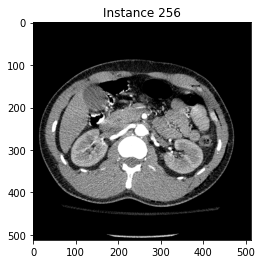

In [8]:
from IPython import display
%matplotlib inline

for i in range(img3d.shape[0]):
  img = img3d[i]
  imgplt = plt.imshow(img, cmap='gray')
  display.clear_output(wait=True)
  plt.title(f'Instance {i}')
  plt.show()

**Coronal, Sagital and Axial views**

Com a imagem 3D representando toda a série, agora podemos projetá-la em diferentes eixos, resultando em 3 visualizações diferentes:

- **Coronal:** a visão indo da frente do paciente para as costas;
- **Sagital:** a visão que vai do lado esquerdo do paciente para o seu lado direito;
- **Axial:** a visão que vai da cabeça do paciente aos pés.

A série usada aqui está originalmente na vista axial, como podemos ver na célula anterior. Isso significa que cada corte se move no eixo Z, que é relativo ao eixo da cabeça aos pés do paciente. Para verificar a imagem 3D em cada visualização, podemos simplesmente percorrer cada fatia sequencialmente, como fizemos na célula anterior, ou podemos simplesmente obter uma média de todos os pixels ao longo de um determinado eixo. A média sobre cada eixo resulta em uma visualização diferente (com exceção da última dimensão, que está associada ao número de canais).

(257, 512, 512)


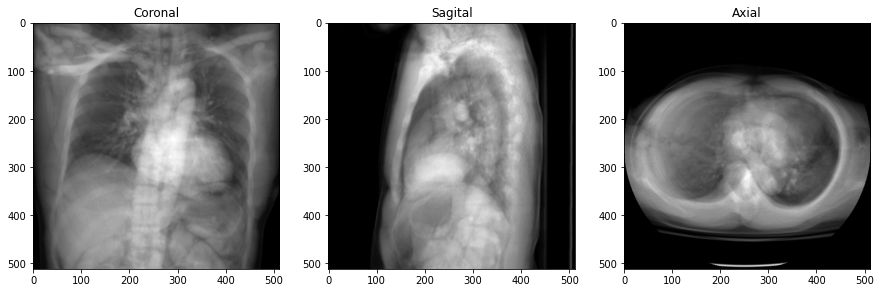

In [9]:
from skimage.transform import resize

print(img3d.shape)
img_ax = np.mean(img3d, axis=0)
img_cor = np.mean(img3d, axis=1)
img_sag = np.mean(img3d, axis=2)

img_cor = resize(img_cor, (512,512), preserve_range=True)
img_sag = resize(img_sag, (512,512), preserve_range=True)

f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(img_cor, cmap='gray')
axarr[0].title.set_text('Coronal')
axarr[1].imshow(img_sag, cmap='gray')
axarr[1].title.set_text('Sagital')
axarr[2].imshow(img_ax, cmap='gray')
axarr[2].title.set_text('Axial')

É interessante notar que a visão coronal (usando a operação média) da tomografia computadorizada é muito semelhante a um exame de raio-x. Esta é apenas uma maneira prática de mostrar que uma tomografia computadorizada é semelhante a uma radiografia 3D.

Mais uma vez, vamos embutir essas operações dentro de uma função, para que possamos usá-la mais facilmente. Esta função receberá o dataframe construído usando a função get_valid_files_in_folder e um id de série dentro deste dataframe. Vamos então construir a imagem 3D dessa série e devolvê-la.

In [10]:
def get_series_arr(df, series_id, window_center=None, window_width=None):
  df_ser = df[df['SeriesInstanceUID'] == series_id]
  df_ser = df_ser.sort_values(by=['InstanceNumber'])
  df_ser.reset_index(drop=True, inplace=True)
  img3d = []
  for row in df_ser.iterrows():
    file = row[1]['path']
    inst_number = row[1]['InstanceNumber']
    img = utils.get_dicom_img(file, window_center, window_width)
    img3d.append(img)
  img3d = np.array(img3d)

  return img3d

Agora podemos usar esta função para cada série em nosso dataframe e plotar suas visualizações coronal, sagital e axial:

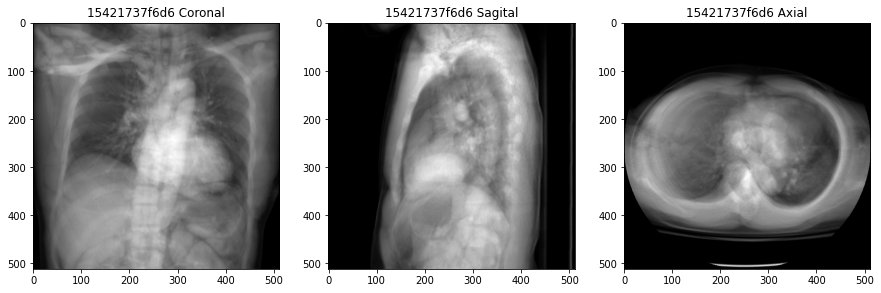

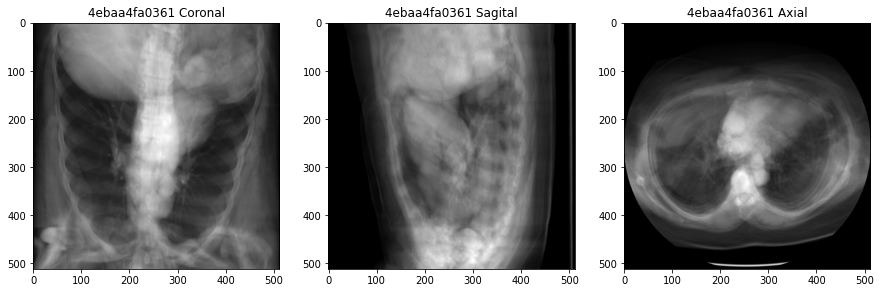

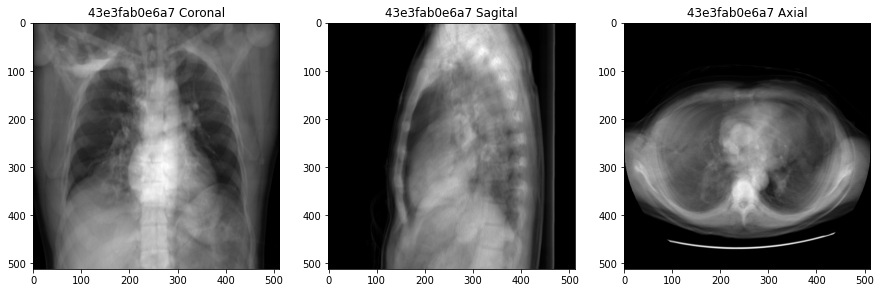

In [11]:
for series in df['SeriesInstanceUID'].unique():

  img3d = get_series_arr(df, series)

  img_ax = np.mean(img3d, axis=0)
  img_cor = np.mean(img3d, axis=1)
  img_sag = np.mean(img3d, axis=2)

  img_cor = resize(img_cor, (512,512), preserve_range=True)
  img_sag = resize(img_sag, (512,512), preserve_range=True)

  f, axarr = plt.subplots(1, 3, figsize=(15,15))
  axarr[0].imshow(img_cor, cmap='gray')
  axarr[0].title.set_text(f'{series} Coronal')
  axarr[1].imshow(img_sag, cmap='gray')
  axarr[1].title.set_text(f'{series} Sagital')
  axarr[2].imshow(img_ax, cmap='gray')
  axarr[2].title.set_text(f'{series} Axial')


**Ordering the Slices using InstanceNumber and ImagePositionPatient**

Como podemos ver no exemplo anterior, a última série estava de cabeça para baixo. O que deu errado?

Para investigar isso ainda mais, vamos examinar as tags InstanceNumber e ImagePositionPatient. Como dissemos anteriormente, a tag ImagePositionPatient indica a localização dos eixos X, Y e Z de cada fatia no espaço 3D. Como esta série está originalmente na vista axial, os valores X e Y para cada fatia devem permanecer os mesmos (ou pelo menos variar pouco) de uma fatia para outra (lembre-se de que ordenamos nosso dataframe de acordo com o id da série e o número da instância). Em teoria, o valor do eixo Z aumenta na direção da cabeça do paciente e diminui movendo-se para os pés (considerando o dataframe ordenado com base no número da instância) (você pode conferir mais detalhes neste, neste e neste link). Portanto, esperamos esse comportamento para as duas séries (exibidas acima) que não são invertidas e o comportamento oposto para a última série.

Vamos primeiro verificar a diferença dos valores de ImagePositionPatient para a primeira fatia e a 10ª fatia da série '4ebaa4fa0361' (não invertida):

In [12]:
series_id = '43e3fab0e6a7'
df_ser = df[df['SeriesInstanceUID'] == series_id]
df_ser = df_ser.sort_values(by=['InstanceNumber'])
img_pos = df_ser['ImagePositionPatient'].to_list()
instance = df_ser['InstanceNumber'].to_list()
print(f'Instance = {instance[0]} --- ImagePositionPatient = {img_pos[0]}')
print(f'Instance = {instance[10]} --- ImagePositionPatient = {img_pos[10]}')

Instance = 1 --- ImagePositionPatient = [-175.400, -192.500, -1.500]
Instance = 11 --- ImagePositionPatient = [-175.400, -192.500, -14.000]


Como podemos ver, de fato o eixo Z da tag ImagePositionPatient é maior para cortes mais próximos da cabeça (o primeiro corte) e menor para cortes mais próximos dos pés (o 10º corte), ou seja, o eixo Z do ImagePositionPatient é diminuindo de acordo com as fatias ordenadas de acordo com o número da instância. Agora vamos verificar o que acontece para a série '4ebaa4fa0361' (invertida):

In [14]:
series_id = '4ebaa4fa0361'
df_ser = df[df['SeriesInstanceUID'] == series_id]
df_ser = df_ser.sort_values(by=['InstanceNumber'])
img_pos = df_ser['ImagePositionPatient'].to_list()
instance = df_ser['InstanceNumber'].to_list()
print(f'Instance = {instance[0]} --- ImagePositionPatient = {img_pos[0]}')
print(f'Instance = {instance[10]} --- imagePositionPatient = {img_pos[10]}')

Instance = 1 --- ImagePositionPatient = [-180.500, -180.500, -304.250]
Instance = 11 --- imagePositionPatient = [-180.500, -180.500, -291.750]


Como esperado, podemos ver o comportamento oposto: o eixo Z da tag ImagePositionPatient está aumentando à medida que aumentamos o número da instância. Isso significa que o primeiro corte está mais próximo dos pés, não mais próximo da cabeça (como estava acontecendo no exemplo anterior). Portanto, neste caso, precisamos inverter a imagem 3D na dimensão da fatia. Então, vamos reescrever nosso get_series_arr incluindo este comportamento:

In [17]:
def get_series_arr_with_flip(df, series_id, window_center=None, window_width=None):
  df_ser = df[df['SeriesInstanceUID'] == series_id]
  df_ser = df_ser.sort_values(by=['InstanceNumber'])
  df_ser.reset_index(drop=True, inplace=True)
  img3d = []
  flip = False
  prev_img_pos_z = None
  for row in df_ser.iterrows():
    file = row[1]['path']
    img = utils.get_dicom_img(file, window_center, window_width)
    img3d.append(img)

    img_pos_z =row[1]['ImagePositionPatient'][2]
    if prev_img_pos_z is not None and prev_img_pos_z < img_pos_z:
      flip = True
    prev_img_pos_z = img_pos_z

  img3d = np.array(img3d)
  if flip:
    img3d = np.flip(img3d, axis=0)

  return img3d

Agora, vamos testá-lo em ação:

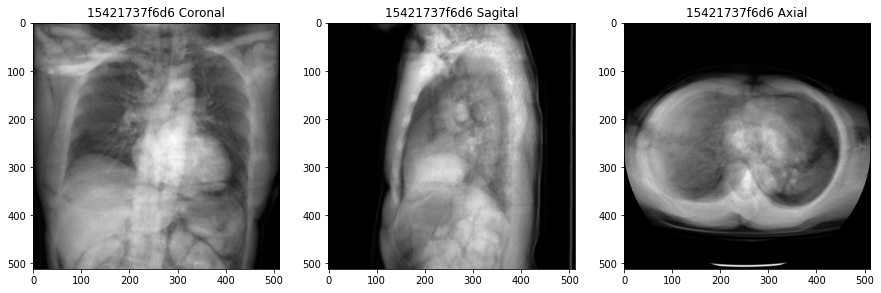

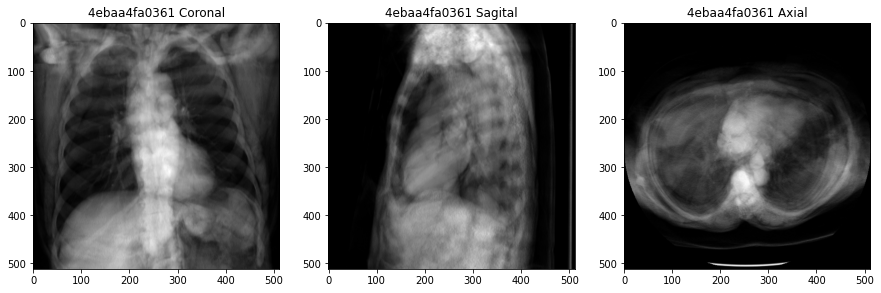

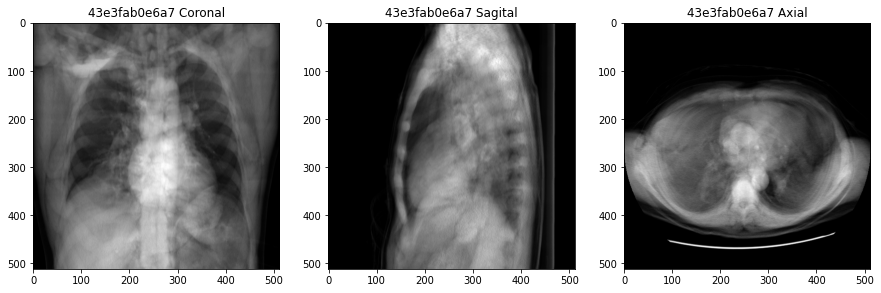

In [19]:
for series in df['SeriesInstanceUID'].unique():

  img3d = get_series_arr_with_flip(df, series, window_center=30, window_width=150)

  img_ax = np.mean(img3d, axis=0)
  img_cor = np.mean(img3d, axis=1)
  img_sag = np.mean(img3d, axis=2)

  img_cor = resize(img_cor, (512, 512), preserve_range=True)
  img_sag = resize(img_sag, (512, 512), preserve_range=True)

  f, axarr = plt.subplots(1, 3, figsize=(15,15))
  axarr[0].imshow(img_cor, cmap='gray')
  axarr[0].title.set_text(f'{series} Coronal')
  axarr[1].imshow(img_sag, cmap='gray')
  axarr[1].title.set_text(f'{series} Sagital')
  axarr[2].imshow(img_ax, cmap='gray')
  axarr[2].title.set_text(f'{series} Axial')

**Updating the utils Module**

Por fim, vamos atualizar o módulo utils e inserir as novas funções desenvolvidas aqui. Usaremos get_series_arr_with_flip como a função final para obter uma imagem 3D de uma série. Criaremos o arquivo utils_pt2.py e nomearemos esta função simplesmente como get_series_arr.